In [77]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import re

# Loading data

Data can be downloaded as a `zip` file at https://drive.google.com/file/d/1h0ThrK252cyeJr4TwkqQCNKJhGMji-4B/view?usp=sharing

It contains the following files:

- `newspapers.jsonl` 190MB, 100 000 articles
- `newspapers_sample.jsonl` 200KB, 100 articles

Extract them to the project's root directory.

JSONL is a file format that contains a sequence of JSON objects, each object in a separate line.


In [78]:
from json import loads, dumps

data_sample = [
    loads(line)
    for line in open("data/newspapers_sample.jsonl", "r", encoding="utf-8").readlines()
]

data = [
    loads(line)
    for line in open("data/newspapers.jsonl", "r", encoding="utf-8").readlines()
]

data_sample[:3]

[{'text': 'On ne s‚Äôattendait pas du tout √† trouver une ville aussi jolie entour√©e de remparts. ¬ª La surprise √©merveille plus d‚Äôun touriste, qu‚Äôil soit fran√ßais ou √©tranger, quand il d√©couvre Angoul√™me. Le Plateau et ses ruelles surprennent. Et surtout s√©duisent. Notamment les √©trangers dont on f√™te le grand retour, cette ann√©e, apr√®s deux √©t√©s de disette en raison de la crise sanitaire.\n\nBelges, Britanniques et N√©erlandais constituent le hit de parade des nationalit√©s repr√©sent√©es depuis d√©but juillet. On croise √©galement des Espagnols, des Italiens et quelques Nord-Am√©ricains. Et m√™me des Danois, accueillis pour la premi√®re fois au Mus√©e d‚Äôart et d‚Äôhistoire de la ville. ¬´ Peut-√™tre gr√¢ce au Tour de France ! ¬ª, avance-t-on dans un sourire √† l‚Äôaccueil.\n\nLes Anglo-Saxons et les vieilles pierres\n\nDifficile de dire si le label ¬´ Ville cr√©ative ¬ª, d√©livr√© par l‚ÄôUnesco fin 2019, p√®se sur la venue d‚Äô√©trangers dans la ville. Peu semble

### Fields

What are the fields of the JSON objects?


In [79]:
keys = {key for item in data for key in item.keys()}
keys

{'article', 'date', 'text', 'title'}

### Transform the json objects in dataframes


In [80]:
df = pd.DataFrame(data)
df_sample = pd.DataFrame(data_sample)

In [81]:
df["date"]

0        2022-03-07T00:00:00.000
1        2023-11-26T00:00:00.000
2        2023-09-06T00:00:00.000
3        2022-11-09T00:00:00.000
4        2022-03-11T00:00:00.000
                  ...           
99995    2022-07-04T00:00:00.000
99996    2022-11-29T00:00:00.000
99997    2023-02-21T00:00:00.000
99998    2022-08-29T00:00:00.000
99999    2022-03-10T00:00:00.000
Name: date, Length: 100000, dtype: object

### Parse dates


In [82]:
### Parse dates

df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%dT%H:%M:%S.%f")

### Any missing values? (No)


In [83]:
df.isnull().sum()

text       0
title      0
date       0
article    0
dtype: int64

# Lengths of titles and texts


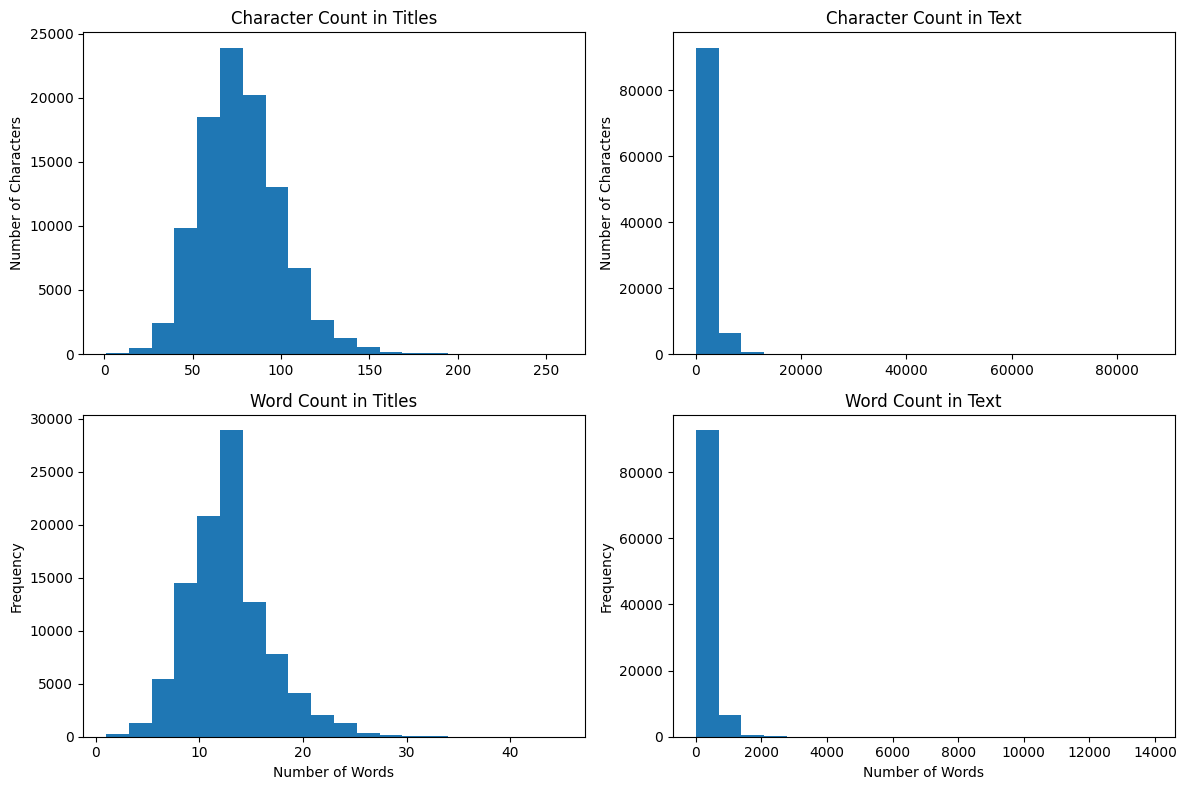

In [84]:
# Calculate the number of characters in titles and text
df["title_char_count"] = df["title"].str.len()
df["text_char_count"] = df["text"].str.len()

# Calculate the number of words in titles and text
df["title_word_count"] = df["title"].str.split().str.len()
df["text_word_count"] = df["text"].str.split().str.len()

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Boxplot of character count in titles
axs[0, 0].hist(df["title_char_count"], bins=20)
axs[0, 0].set_title("Character Count in Titles")
axs[0, 0].set_ylabel("Number of Characters")

# Boxplot of character count in text
axs[0, 1].hist(df["text_char_count"], bins=20)
axs[0, 1].set_title("Character Count in Text")
axs[0, 1].set_ylabel("Number of Characters")

# Histogram of word count in titles
axs[1, 0].hist(df["title_word_count"], bins=20)
axs[1, 0].set_title("Word Count in Titles")
axs[1, 0].set_xlabel("Number of Words")
axs[1, 0].set_ylabel("Frequency")

# Histogram of word count in text
axs[1, 1].hist(df["text_word_count"], bins=20)
axs[1, 1].set_title("Word Count in Text")
axs[1, 1].set_xlabel("Number of Words")
axs[1, 1].set_ylabel("Frequency")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [85]:
# Show the longuest titles
longuest_titles = df.sort_values("title_char_count", ascending=False).head(200)

longuest_titles[["title", "title_char_count"]]

title  title_char_count
42978  L'essentiel du sport dans nos r√©gions. Antoine...               259
48421  En image | ddddddddddddddddddddddddddddddddddd...               249
28621  La Su√©doise Linn Grant regarde son drive, au d...               248
91553  La Matinale. Pierre Palmade gravement bless√© d...               245
27317  L'essentiel du sport dans nos r√©gions. Premier...               238
...                                                  ...               ...
99320  Des naturalistes d'Alsace Bossue mobilis√©s con...               165
11647  M√¢con (communiqu√© ). La commission des finance...               165
77353  Disparition d'Alex Batty : "Il nous accompagna...               165
16987  Un 47eme fourgon d'intervention percut√© sur l'...               165
15861  M√©t√©o. De Grenoble √† Mont√©limar, d'Annecy √† Av...               165

[200 rows x 2 columns]

### Repeating characters


- We found the text `dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddeeeeeeeeeeeeeeeeeeeePose`in a title.
  It might be useful to count the number of repeating characters in the text.


In [86]:
def count_repeating_chars(text: str) -> int:
    """Count the number of repeating characters in a string.

    Example:
    count_repeating_chars('aab') -> 1
    count_repeating_chars('aaabb') -> 3
    """
    count = 0
    for i in range(1, len(text)):
        if text[i] == text[i - 1]:
            count += 1
    return count


assert count_repeating_chars("aab") == 1
assert count_repeating_chars("aaabb") == 3

In [87]:
def count_repeating_non_whitespace_chars(text: str) -> int:
    """Count the number of repeating non-whitespace characters in a string.

    Example:
    count_repeating_non_whitespace_chars('aab') -> 1
    count_repeating_non_whitespace_chars('aaabb') -> 3
    count_repeating_non_whitespace_chars('aa a') -> 2
    """
    text = text.replace(" ", "").replace("\n", "").replace("\t", "").replace("\r", "")
    return count_repeating_chars(text)


assert count_repeating_non_whitespace_chars("aab") == 1
assert count_repeating_non_whitespace_chars("aaabb") == 3
assert count_repeating_non_whitespace_chars("aa a") == 2

Only counting the number of repeating characters in the text would penalize long texts. We should normalize this number by the length of the text.


In [88]:
# Count repeating characters in titles and text and dividing by the number of characters

df["title_repeating_chars"] = (
    df["title"].apply(count_repeating_non_whitespace_chars) / df["title_char_count"]
)
df["text_repeating_chars"] = (
    df["text"].apply(count_repeating_non_whitespace_chars) / df["text_char_count"]
)

In [89]:
# Show the rows with the highest ratio of repeating characters in titles
df.sort_values("title_repeating_chars", ascending=False).head(10)[
    ["title", "title_repeating_chars"]
]

title  \
48421  En image | ddddddddddddddddddddddddddddddddddd...   
34828                                               ZOOM   
16286                                          495¬†000 ‚Ç¨   
9521   XXXXXXXXX. Une l√©gislation qui √©volue en perma...   
22558                         500 √† sillonner le terroir   
73655                        Comment placer 50 000 euros   
82484                              Halloween en familles   
12681  Football. ASSE : le successeur de Laurent Batl...   
63319                          On a test√©...l'attelage !   
52597        Un football lorrain au fort accent polonais   

       title_repeating_chars  
48421               0.510040  
34828               0.250000  
16286               0.222222  
9521                0.176471  
22558               0.153846  
73655               0.148148  
82484               0.142857  
12681               0.121212  
63319               0.120000  
52597               0.116279

In [90]:
# Same for text
df.sort_values("text_repeating_chars", ascending=False).head(10)[
    ["title", "text", "text_repeating_chars"]
]

title  \
48421  En image | ddddddddddddddddddddddddddddddddddd...   
56337     Confolens¬†: Le prix Abel Desaphy disput√© jeudi   
92943  Football : d√©couvrez les affiches du 5e tour d...   
26287   Aveyron : suivez le week-end de sports en direct   
73389  Football, basket-ball, handball : suivez les r...   
27180  Football, handball, trail : retrouvez tous les...   
95416  Rugby, football, basket-ball : suivez en direc...   
64024  Football, auto, basket-ball : suivez en direct...   
55529  Basket-ball, rugby, football : d√©couvrez tous ...   
81783  Football, basket-ball, rugby : le Sporting dec...   

                                                    text  text_repeating_chars  
48421  En image | ddddddddddddddddddddddddddddddddddd...              0.414791  
56337  Pour les √©preuves d‚Äô√©cole de v√©lo, les dossard...              0.314079  
92943  ????? ?? ?????? : ???????? ?? ?? ???? \ud83c\u...              0.235808  
26287  Football, basket-ball, handball, moto ou encor...              0.205108  
73389  Suivez ci-dessous l'avanc√©e des r√©sultats spor...              0.175405  
27180  Retrouvez ci-dessous l'ensemble des r√©sultats ...              0.135633  
95416  Football, rugby √† XIII et √† XV, handball, bask...              0.119357  
64024  Football, rugby √† XIII, handball, automobile.....              0.101159  
55529  Basket-ball, football, handball, rugby....Retr...              0.100370  
81783  Football, rugby √† XIII et √† XV, handball, cour...              0.093532

Turns out the only problematic text is the one mentioned above.


In [91]:
# Drops rows having a title with more than 0.50 repeating characters score
df = df[df["title_repeating_chars"] < 0.50]

### Looking at the shortests titles


In [92]:
df.sort_values("title_char_count").head(10)[["title", "title_char_count", "text"]]

title  title_char_count  \
59191         8                 1   
85033       164                 3   
43755      3,38                 4   
34828      ZOOM                 4   
62470    L'Ou√Øe                 6   
87771   Vite lu                 7   
92692   ‚û§ ‚ÄÇVoir                 7   
49896   Vite lu                 7   
2078    Rep√®res                 7   
6891   contexte                 8   

                                                    text  
59191  ...pour lire la suite, rejoignez notre communa...  
85033  164\n\nC‚Äôest en millions d‚Äôeuros, la somme des...  
43755  en millions d‚Äôeuros, c‚Äôest le montant de l‚Äôenv...  
34828  ZOOM\n\nPar Le Progr√®s - Hier √† 18:37 - Temps ...  
62470  Entendre c‚Äôest aussi se donner le temps d‚Äôappr...  
87771  Arbres abattus avenue du 8-Mai-1945. Les agent...  
92692  ‚û§ Voir\n\nPar Le Bien Public - Aujourd'hui √† 1...  
49896  Concert avec dimanche avec Franck Besingrand. ...  
2078   Rep√®res\n\nPar Le Dauphin√© Lib√©r√© - Aujourd'hu...  
6891   ...pour lire la suite, rejoignez notre communa...

Let's find titles which only consists of numbers and special characters


In [93]:
import string

FRENCH_LETTERS = string.ascii_letters + "√†√¢√ß√©√®√™√´√Æ√Ø√¥√ª√º√ø√¶≈ì"
FRENCH_LETTERS

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ√†√¢√ß√©√®√™√´√Æ√Ø√¥√ª√º√ø√¶≈ì'

In [94]:
def get_only_alpha_text(text: str, alphabset_set=FRENCH_LETTERS) -> str:
    """Return a string containing only the letters of the input string.

    Example:
    get_only_alpha_text("Hello, world 23,1!") -> "Helloworld"
    """
    return "".join([c for c in text if c in alphabset_set])


assert get_only_alpha_text("Hello, world 23,1!") == "Helloworld"

In [95]:
# Create a new column with only the letters of the title

df["title_alpha"] = df["title"].apply(get_only_alpha_text)

# Create a new column with the number of chars in title_alpha

df["title_alpha_char_count"] = df["title_alpha"].str.len()

# Show the rows with the shortest title_alpha
df.sort_values("title_alpha_char_count").head(100)[
    ["title", "title_alpha", "title_alpha_char_count"]
]

title     title_alpha  title_alpha_char_count
16286           495¬†000 ‚Ç¨                                       0
43755                3,38                                       0
59191                   8                                       0
85033                 164                                       0
34828                ZOOM            ZOOM                       4
...                   ...             ...                     ...
17074  SAVOIE. √âtat civil  SAVOIEtatcivil                      14
47951  SAVOIE. √âtat civil  SAVOIEtatcivil                      14
89156  Moselle. Et aussi‚Ä¶  MoselleEtaussi                      14
16206  SAVOIE. √âtat civil  SAVOIEtatcivil                      14
82551  SAVOIE. √âtat civil  SAVOIEtatcivil                      14

[100 rows x 3 columns]

We remove the rows having titles with less than 10 alpha characters


In [96]:
# We remove the rows having titles with less than 10 alpha characters
before_len = len(df)
df = df[df["title_alpha_char_count"] >= 10]
after_len = len(df)

print(f"Removed {before_len - after_len} rows")

Removed 37 rows


# Url


### Extract URL


In [97]:
import validators
from typing import Tuple, Optional

Url = str


def extract_id_and_url(article: str) -> Tuple[Optional[str], Optional[Url]]:
    if " at " in article:
        id, url = article.split(" at ")
        assert validators.url(url)
        return id, url

    url = article.strip("tag:")
    if not validators.url(article):
        return None, None

    return None, url


assert extract_id_and_url(
    "2047761 at https://france3-regions.francetvinfo.fr/occitanie"
) == ("2047761", "https://france3-regions.francetvinfo.fr/occitanie")
assert extract_id_and_url("https://france3-regions.francetvinfo.fr/occitanie") == (
    None,
    "https://france3-regions.francetvinfo.fr/occitanie",
)

df["article_id"], df["article_url"] = zip(*df["article"].apply(extract_id_and_url))

df.head()

text  \
0  L'international de p√©tanque de S√®te, avait lie...   
1  Ce contenu est bloqu√© car vous n'avez pas acce...   
2  Le tribunal de commerce de Chamb√©ry va conna√Æt...   
3  La 38e campagne d‚Äôhiver de l‚Äôassociation comme...   
4  Sur le m√™me sujet Dordogne : contre le cancer ...   

                                               title       date  \
0  International de S√®te : la p√©tanque, une affai... 2022-03-07   
1  Massif des Vosges. La route des Cr√™tes ferm√©e ... 2023-11-26   
2  Savoie. Discrimination raciale: quatre chauffe... 2023-09-06   
3  T√âMOIGNAGE. Les Restos du Coeur recrutent : "o... 2022-11-09   
4  Mars bleu, pour favoriser le d√©pistage du canc... 2022-03-11   

                                             article  title_char_count  \
0  2047761 at https://france3-regions.francetvinf...                74   
1  https://www.vosgesmatin.fr/environnement/2023/...                70   
2  https://www.ledauphine.com/faits-divers-justic...               102   
3  2651444 at https://france3-regions.francetvinf...                97   
4  https://www.sudouest.fr/dordogne/thiviers/mars...                77   

   text_char_count  title_word_count  text_word_count  title_repeating_chars  \
0             2397                13              411               0.027027   
1              594                13               95               0.014286   
2              397                13               64               0.019608   
3             4721                17              793               0.030928   
4              853                12              131               0.000000   

   text_repeating_chars                                        title_alpha  \
0              0.026283  InternationaldeS√®telap√©tanqueuneaffairedefamil...   
1              0.026936  MassifdesVosgesLaroutedesCr√™tesferm√©e√†partirdu...   
2              0.027708  SavoieDiscriminationracialequatrechauffeurspor...   
3              0.026477  TMOIGNAGELesRestosduCoeurrecrutentonestnourrid...   
4              0.017585  Marsbleupourfavoriserled√©pistageducancercolore...   

   title_alpha_char_count article_id  \
0                      60    2047761   
1                      56       None   
2                      88       None   
3                      75    2651444   
4                      64       None   

                                         article_url  
0  https://france3-regions.francetvinfo.fr/occitanie  
1  https://www.vosgesmatin.fr/environnement/2023/...  
2  https://www.ledauphine.com/faits-divers-justic...  
3  https://france3-regions.francetvinfo.fr/occita...  
4  https://www.sudouest.fr/dordogne/thiviers/mars...

In [98]:
### Extract the domain name from the URL

from urllib.parse import urlparse


def extract_domain(url: Url) -> str:
    return urlparse(str(url)).netloc.strip(".www")


assert (
    extract_domain("https://france3-regions.francetvinfo.fr/occitanie")
    == "france3-regions.francetvinfo.fr"
)

df["article_domain"] = df["article_url"].apply(extract_domain)
df.head(3)

text  \
0  L'international de p√©tanque de S√®te, avait lie...   
1  Ce contenu est bloqu√© car vous n'avez pas acce...   
2  Le tribunal de commerce de Chamb√©ry va conna√Æt...   

                                               title       date  \
0  International de S√®te : la p√©tanque, une affai... 2022-03-07   
1  Massif des Vosges. La route des Cr√™tes ferm√©e ... 2023-11-26   
2  Savoie. Discrimination raciale: quatre chauffe... 2023-09-06   

                                             article  title_char_count  \
0  2047761 at https://france3-regions.francetvinf...                74   
1  https://www.vosgesmatin.fr/environnement/2023/...                70   
2  https://www.ledauphine.com/faits-divers-justic...               102   

   text_char_count  title_word_count  text_word_count  title_repeating_chars  \
0             2397                13              411               0.027027   
1              594                13               95               0.014286   
2              397                13               64               0.019608   

   text_repeating_chars                                        title_alpha  \
0              0.026283  InternationaldeS√®telap√©tanqueuneaffairedefamil...   
1              0.026936  MassifdesVosgesLaroutedesCr√™tesferm√©e√†partirdu...   
2              0.027708  SavoieDiscriminationracialequatrechauffeurspor...   

   title_alpha_char_count article_id  \
0                      60    2047761   
1                      56       None   
2                      88       None   

                                         article_url  \
0  https://france3-regions.francetvinfo.fr/occitanie   
1  https://www.vosgesmatin.fr/environnement/2023/...   
2  https://www.ledauphine.com/faits-divers-justic...   

                    article_domain  
0  france3-regions.francetvinfo.fr  
1                   vosgesmatin.fr  
2                   ledauphine.com

# Removing cookies banners, paywalls, and other non-content text


### "Pour lire la suite"


In [99]:
# We want to know what's after "pour lire la suite". We will extract the next 20 characters after the match, put them in a set, and display the set.
# This will give us an idea of the different ways this sentence is completed.

pour_lire_la_suite = df["text"].str.contains("pour lire la suite", case=False)

df[pour_lire_la_suite]["text"].str.extract(
    r"pour lire la suite(.{20})", flags=re.IGNORECASE
)[0].unique()

array([', rejoignez notre co', ', abonnez-vous : D√©c',
       ', abonnez-vous : Dec', ' de cet article et a'], dtype=object)

When "Pour lire la suite" appears in the text, it's always followed by

- `, rejoignez notre communaut√©`
- `, abonnez-vous`
- ` de cet article`

So the text "Pour lire la suite" is never a part of the article. We can safely characterize them as "paywall"


In [100]:
# mark the rows where the text contains "pour lire la suite"
# For all rows of `pour_lire_la_suite`, mark the "content_restrictions" column as "paywall"

df.loc[pour_lire_la_suite, "content_restrictions"] = "paywall"

print(f"Marked {pour_lire_la_suite.sum()} rows as paywall")

Marked 6058 rows as paywall


### Other restrictions


In [101]:
COOKIE_WALL_TRIGGER = [
    "Ce contenu est bloqu√© car vous n'avez pas accept√© les cookies.",
    "Ce contenu est bloqu√© car vous n'avez pas accept√© les traceurs",
    "En cliquant sur ¬´ J‚Äôaccepte tous les cookies ¬ª",
    "Deconnectez-vous systematiquement avant de fermer la fenetre du navigateur",
    "D√©connectez-vous syst√©matiquement avant de fermer la fen√™tre du navigateur",
    "En acceptant les cookies, vous pourrez acc√©der aux contenus et fonctionnalit√©s gratuites que propose notre site.",
    "but your activity and behavior on this site made us think that you are a bot",
"Nous utilisons des cookies ou technologies",
"Ce contenu est bloque car",
"Si vous souhaitez modifier vos centres d'int√©r√™t, vous pouvez √† tout moment cliquer sur le lien",
]

cookies = df["text"].str.contains("|".join(COOKIE_WALL_TRIGGER), case=False)

df.loc[cookies, "content_restrictions"] = "cookie-wall"

print(f"Marked {cookies.sum()} rows as cookie-wall")

Marked 6328 rows as cookie-wall


In [102]:
PAYWALL_TRIGGER = [
    "Cet article est r√©serv√© aux abonn√©s.",
    "Abonnez-vous pour 1‚Ç¨ Acc√©dez en illimit√© √† tous les dossiers",
    "Abonnez-vous pour 1‚Ç¨",
    "R√©serv√© aux abonn√©s",
    "En cliquant sur ¬´ je m‚Äôabonne ¬ª",
]


paywall = df["text"].str.contains("|".join(PAYWALL_TRIGGER), case=False)


df.loc[paywall, "content_restrictions"] = "paywall"

print(f"Marked {paywall.sum()} rows as paywall")

Marked 841 rows as paywall


In [103]:
PODCAST_TRIGGER = [
    "√âcoutez cet √©pisode et abonnez-vous",
    "Ecoutez cet √©pisode et abonnez-vous",
    "sur votre plateforme audio favorite",
]

podcast = df["text"].str.contains("|".join(PODCAST_TRIGGER), case=False)

df.loc[podcast, "content_restrictions"] = "podcast"

In [104]:
NEWSLETTER_TRIGGER = [
    "Nos journalistes s√©lectionnent pour vous les articles essentiels de votre secteur",
    "Votre adresse email n'est pas valide",
    "S'abonner √† la newsletter\n\nS'abonner √† la newsletter",
]

newsletter = df["text"].str.contains("|".join(NEWSLETTER_TRIGGER), case=False)

df.loc[newsletter, "content_restrictions"] = "newsletter"

print(f"Marked {newsletter.sum()} rows as newsletter")

Marked 595 rows as newsletter


What is missing ?


In [105]:
not_restricted = df[df["content_restrictions"].isnull()]


TRIGGER_WORDS = [
    "cookie",
    "abonnez-vous",
    "inscrivez-vous",
    "connectez-vous",
    "et acc√©dez √† l'int√©gralit√© de nos articles sur le site et l'application mobile",
    "Je d√©couvre",
    "√† partir de 1 ‚Ç¨ le 1er mois",
    "sans engagement de dur√©e",
    "ce contenu est bloqu√©",
    "r√©serv√© aux abonn√©s",
    "vous n'avez pas accept√© les cookies et autres traceurs"
    "En cliquant sur ¬´ J"
    "√† 1‚Ç¨",
]

# Let's find rows having the trigger words in the text, in the rest df
trigger_words = not_restricted["text"].str.contains("|".join(TRIGGER_WORDS), case=False)

In [106]:
# For each row in rest[trigger_words], print the part of the text containing the trigger word, with 50 characters before and after

parts = set()

for text in not_restricted[trigger_words]["text"]:
    for word in TRIGGER_WORDS:
        if word in text:
            start = text.index(word)
            parts.add(text[start - 100 : start + 100].replace("\n", " "))

for part in parts:
    print(part)
    print()



ibre" o√π des parfums (vanille, caf√©, chocolat) sont associ√©s √† des sauces et des topings (noisette, cookies, caramel etc), la r√©√©dition de la boutique √©ph√©m√®re √† la Cit√© de Carcassonne.

ensable tenue aux couleurs rouge et blanc, typique de la f√™te de Dax.  Pour suivre leurs aventures, connectez-vous sur Facebook √† l‚Äôadresse suivante : https :// www.facebook.com/daxroadtrip/

r du sein, quiz, d√©fis sportifs, concours de photos ou de pompes pour les plus aguerris ! Ventes de cookies et de grenadine ont permis de r√©colter des fonds. ¬´ Ce que j‚Äôai trouv√© int√©ressant, c‚Äôest qu

on magasin √©ph√©m√®re Cookie Way permettant de personnaliser ses biscuits, peut √™tre en imaginant des cookies bars dans des restaurants. De quoi s'atteler √† de nouveaux moments de consommation.

nt lui offrent un avantage concurrentiel technologique face √† la concurrence, l‚Äôinsensibilisant aux cookies tiers, en voie de disparition. Le gain du contrat de McDonald‚Äôs, pourtant client h

Example of false positives:

- `le jour du lancement d'un nouveau format de tweet r√©serv√© aux abonn√©s √† Twitter Blue`
- `pote √† d√©velopper, divers ateliers (informatique, cookies), un plus grand partenariat avec les Ateli`
- `"Je dis aux artisans et aux entrepreneurs : inscrivez-vous sur impots.gouv.fr`


### Summary

In [107]:
df['content_restrictions'].value_counts(dropna=False)

content_restrictions
NaN            86123
paywall         6899
cookie-wall     6328
newsletter       595
podcast           17
Name: count, dtype: int64

In [108]:
print(f'There are still {df["content_restrictions"].isnull().sum()} rows without content restrictions')

There are still 86123 rows without content restrictions


# Duplicates

Are there any duplicates in the data? If so, how many?


In [109]:
# Drop duplicate rows :
df.drop_duplicates(inplace=True)
len(df)

99962

Each row is unique. But there can be multiple articles with the same title for instance.


### Title


In [110]:
title_counts = df["title"].value_counts()
title_counts[title_counts > 1]

title
Vosges. Notre √©dition num√©rique est en ligne                                40
Montagne. $content.Title                                                    38
SAVOIE. √âtat civil                                                          10
Vos rendez-vous culturels : o√π sortir √† S√®te et sur le bassin de Thau        8
Le sociorama de la semaine                                                   8
                                                                            ..
En Allemagne, la laborieuse r√©ouverture des centrales √† charbon              2
Cadeaux et bons d'achat offerts aux salari√©s¬†: les limites¬†2023              2
association. Un march√© de No√´l √† l‚Äôafricaine                                 2
Russie. L'insolente vigueur du rouble malgr√© la pluie de sanctions           2
Cette semaine dans les assiettes des √©coliers bagnolais et spiripontains     2
Name: count, Length: 716, dtype: int64

Delete duplicates based on the title


In [111]:
df = df.drop_duplicates(subset="title")

### Text


In [112]:
# show what texts are duplicated, and the number of times they are duplicated

text_counts = not_restricted["text"].value_counts()
text_counts[text_counts >= 2]

text
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Since there are not a lot of duplicates, we can remove all rows having duplicate texts.

In [113]:
# Since there are not a lot of duplicates, we can remove all rows having duplicate texts.

before_len = len(df)

df = df.drop_duplicates(subset="text")

after_len = len(df)

print(f"Removed {before_len - after_len} rows in the whole dataset")

Removed 12799 rows in the whole dataset


# Look at short texts

Check which texts are shorter than their titles

In [114]:
# mark text_restrictions as 'too_short' for rows where the text is shorter than the title
df.loc[df["text"].str.len() < df["title"].str.len(), "content_restrictions"] = "too_short"

In [115]:
# Find texts shorter than N chars :
N = 100
short_texts = df["text"].str.len() < N

df[short_texts][["title", "text", "content_restrictions"]]

title  \
94      Maizilly. La brasserie ouvre ses portes dimanche   
266    √Ä Vannes, Dragon 56 d√©rout√© pour retrouver deu...   
347    Maxime Saint Bonnet, un intermittent du specta...   
1914                            Montagne. $content.Title   
1936   ROMANS-SUR-IS√àRE. D√©part d‚Äôincendie au centre ...   
...                                                  ...   
97905  Loire. Ga√´l Perdriau fait censurer un article ...   
98430                                   Dabo. La recette   
98517  Politique : Royaume-Uni : Penny Mordaunt aband...   
99678                 Momerstroff. Argent de chasse 2022   
99731  Rh√¥ne. Immeuble effondr√© √† Chaponost: pour Lis...   

                                                    text content_restrictions  
94     Maizilly La brasserie ouvre ses portes dimanch...                  NaN  
266                                                                 too_short  
347    Enqu√™te de la r√©daction\n\nLes festivals, poum...                  NaN  
1914   Test de skis : Salomon Stance 88 W, le meilleu...                  NaN  
1936   D√©part d‚Äôincendie au centre N√©gom√©tal\n\nPar L...                  NaN  
...                                                  ...                  ...  
97905  Par Jean-Hugues ALLARD - Hier √† 14:52 | mis √† ...            too_short  
98430  Dabo La recette\n\nPar Le R√©publicain Lorrain ...                  NaN  
98517  IMERYS: Mine de lithium en France : un projet ...            too_short  
99678  Momerstroff Argent de chasse 2022\n\nPar Le R√©...                  NaN  
99731  Par Le Progr√®s - Aujourd'hui √† 14:35 | mis √† j...                  NaN  

[205 rows x 3 columns]

# Explore characters

# Bad titles

In [116]:
# find titles having "$" inside
dollar_titles = df["title"].str.contains(r"\$")
df[dollar_titles][["title", "content_restrictions"]]

#print them all along their text using a loop 
for title, text in df[dollar_titles][["title", "text"]].values:
    print(title)
    print(text.replace("\n", " "))
    print()

Montagne. $content.Title
Test de skis : Salomon Stance 88 W, le meilleur compromis entre piste et poudreuse

Ici, on agit ! . $content.Title
Ici, on agit ! Lacs, rivi√®res et zones humides : des tr√©sors de biodiversit√© Indispensables pour l‚Äôeau potable, l‚Äôirrigation des cultures et la sant√©, les √©cosyst√®mes d‚Äôeau douce sont ...

Haute-Savoie. $content.Title
Le bivouac ou l‚Äôart de camper sans d√©grader la nature

Bourgogne-Franche-Comt√©. $content.Title
Mardi, l‚ÄôAgence r√©gionale de sant√© et l‚Äôassociation Reseda, qui vient en aide aux personnes atteintes de maladies neuro√©volutives et √† leurs proches, ont sign√© un nouveau contrat de trois ans, qui va permettre √† Reseda d‚Äôaccro√Ætre ses activit√©s sur l‚Äôensemble du territoire r√©gional. √Ä lire en page

C√¥te-d‚ÄôOr. $content.Title
C√¥te-d‚ÄôOr Saint-Vincent tournante : on vous dit tout sur les cuv√©es √† d√©guster  Les 19 et 20 mars, dans les douze caveaux de Puligny-Montrachet, Corpeau et Blagny, elles seront 

In [117]:
# remove "$content.Title" from titles
df["title"] = df["title"].str.replace(r"$content.Title", "")

assert not df["title"].str.contains(r"$content.Title").any()

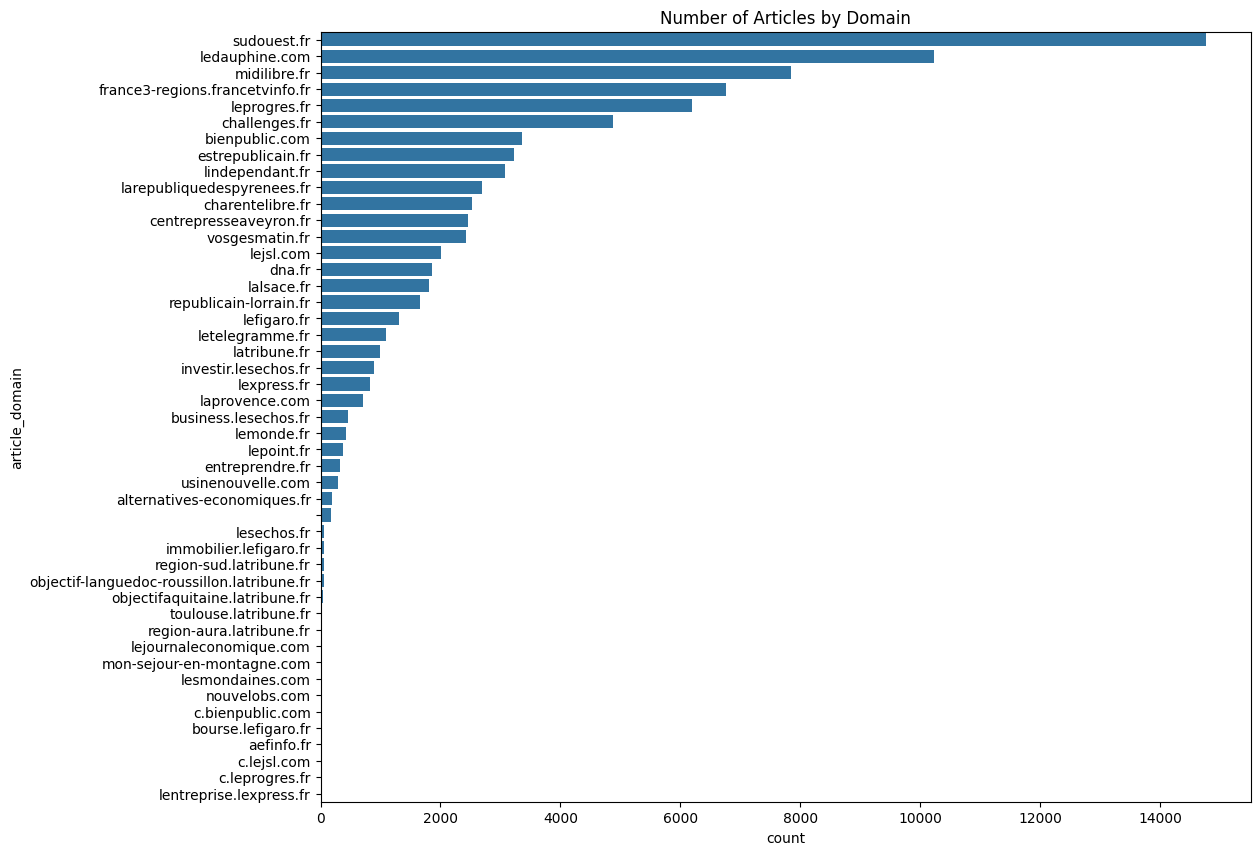

In [118]:
# Number of articles by domain

# Calculate counts
domain_counts = df["article_domain"].value_counts().reset_index()
domain_counts.columns = ['article_domain', 'count']

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(data=domain_counts, y="article_domain", x="count", orient='h')
plt.title("Number of Articles by Domain")
plt.show()

### Content Restrictions by Article Domain

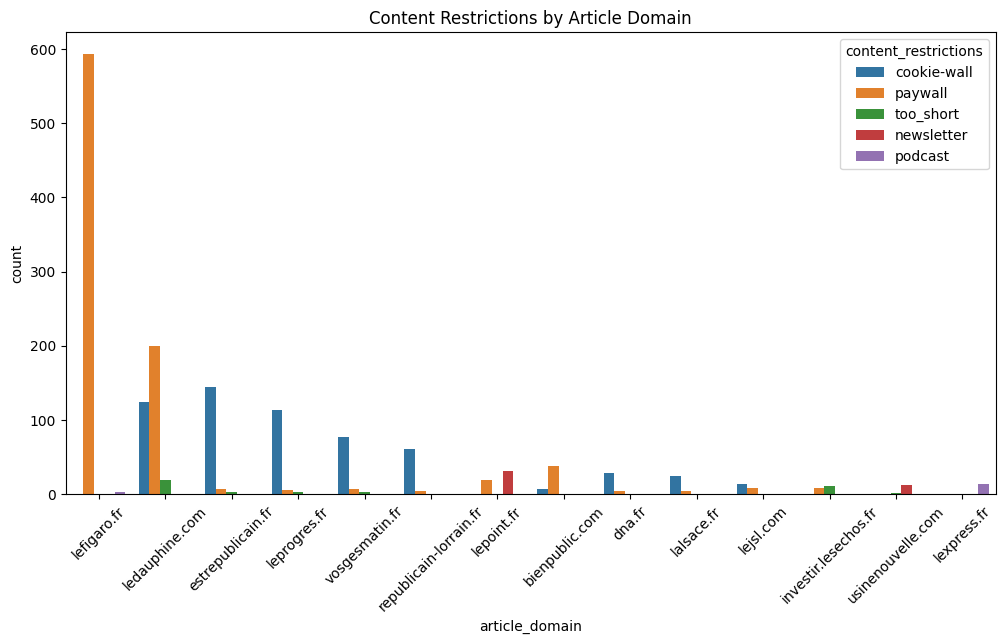

In [119]:
# Content restriction based on article source

restricted = df["content_restrictions"].notnull()

# Calculate counts
counts = df[restricted]["article_domain"].value_counts()

# Only keep counts > 10
counts = counts[counts > 10]

# Create order (sorted by counts)
order = counts.index

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=df[restricted], x="article_domain", hue="content_restrictions", order=order)
plt.xticks(rotation=45)
plt.title("Content Restrictions by Article Domain")
plt.show()



# Word cloud

In [120]:
import nltk
from wordcloud import WordCloud
from wordcloud import STOPWORDS as STOPWORDS_WORDCLOUD

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [121]:
import requests
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-fr/master/stopwords-fr.txt"
github_french_stopwords = requests.get(stopwords_url).text.split()

In [122]:

from nltk.corpus import stopwords
french_stopwords = stopwords.words('french')
STOPWORDS = set(french_stopwords + ["a"] + list(STOPWORDS_WORDCLOUD) + github_french_stopwords)

## Title

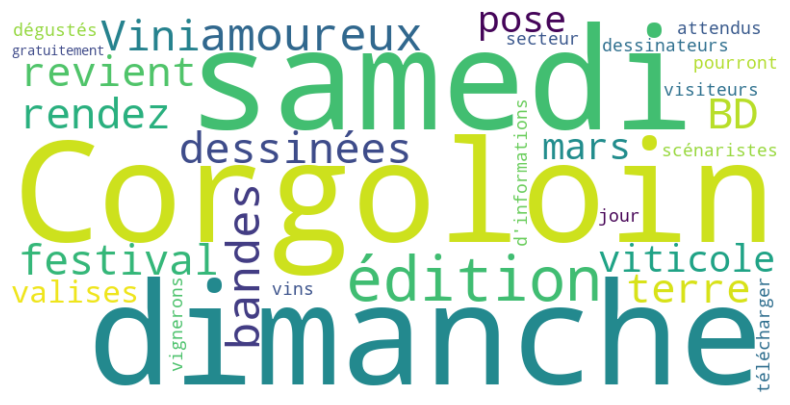

In [123]:
# concatenate all titles in a single string
titles = " ".join(df["title"].values)

wordcloud = WordCloud(width=800, height=400, 
                      background_color="white",
                      stopwords=STOPWORDS,
                      ).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Text

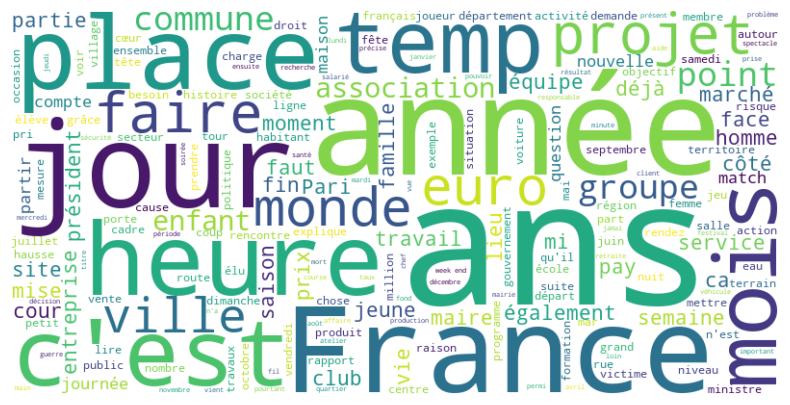

In [124]:
# find text with no restrictions (content_restrictions.isnull) and concatenate all the texts in a single string
text = " ".join(df[df["content_restrictions"].isnull()]["text"].values)

wordcloud = WordCloud(width=800, height=400, 
                      background_color="white",
                      stopwords=STOPWORDS,
                      ).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Date

In [125]:
min_date = df["date"].min()
max_date = df["date"].max()

print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

Min date: 2022-02-11 00:00:00
Max date: 2024-02-13 00:00:00


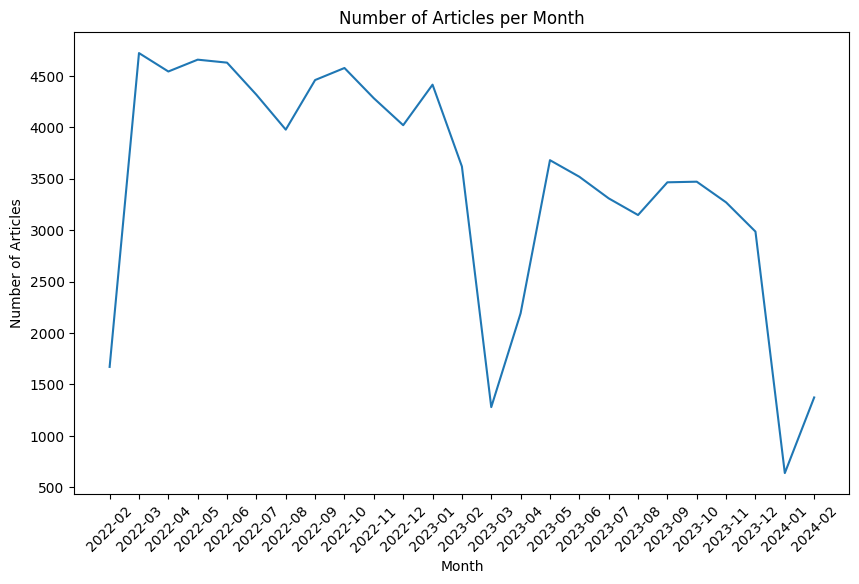

In [126]:
# Group by month and count the number of articles
monthly_counts = df.groupby(df['date'].dt.strftime('%Y-%m'))['date'].count()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts.index, monthly_counts.values)
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Month')
plt.xticks(rotation=45)
plt.show()

# Exportation

In [127]:
from datetime import datetime
FILE_NAME = f"newspapers_filtered_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.jsonl"
COLUMNS = ["title", "text", "article_id", "article_url", "article_domain"]

filtered = df[df['content_restrictions'].isnull()][COLUMNS]

with open(FILE_NAME, "w", encoding="utf-8") as f:
    for item in filtered.to_dict(orient="records"):
        f.write(dumps(item, ensure_ascii=False) + "\n")

print(f"Saved {len(filtered)} rows in {FILE_NAME}")

Saved 84593 rows in newspapers_filtered_2024-04-30_13-55-52.jsonl
